https://www.kaggle.com/code/validmodel/graph-neural-network-starter-for-beginners

## The Basic Math for Graph Structured data

> ### 우리는 픽셀이나 단어를 **하나의 노드 N**이라고 표현할 것임.
> ### 연결성을 표현하기 위해 N x N 행렬을 정의하는데, 이를 인접행렬 A라고 부름. 

> ### 아래의 수식은 Signal이라는 표현식으로, F는 feature의 개수임. 예를들어 RGB 이미지는 F=3(RGB)임. 단어로 따지면 embedding차원임.

## $X \in  R^{N \times F}$

In [7]:
!pip install torchnet networkx

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 22.7 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
  Created wheel for torchnet: filename=torchnet-0.0.4-py3-none-any.whl size=29728 sha256=6dfccb5fcf84777f0be58e916e2dc09c348c63ebbaf85508b943d90a67656c27
  Stored in directory: /Users/jeonghyeonjin/Library/Caches/pip/wheels/c6/64/93/b0f5bb7601f781ab99eb29db201a85ca007fa07af0449eec3c
  Created wheel for visdom: filename=visdom-0.2.4-py3-none-any.whl size=1408197 sha256=086b111ad86c511373074ff692f8b7bc6869460eb6497e613f8108b939410d7e
  Stored in directory: /Users/jeonghyeonjin/Library/Caches/pip/wheels/d7/94/e8/9e718f98bc717d1e6530d59d46e23996cc60cf2a28f1937ed4
Successfully built torchnet visdom


> ### 인접행렬 생성 함수 

In [8]:
import torch

def create_adj(size):
    a = torch.rand(size, size)
    a[a > 0.5] = 1
    a[a <= 0.5] = 0
    # Diagnoal elements set zero
    for i in range(a.shape[0]):
        for j in range(a.shape[1]):
            if i == j:
                a[i, j] = 0

    return a

# Graph Laplacian

> ### 각 노드의 single value를 위해 차수 행렬 D 선언해야함. 그리고, 그래프 연산을 위해 그래프 라플라시안이 필요하다.
> ### 라플라시안의 대각 요소는 노드의 차수를 의미한다(이때, self-loop는 없음), 

In [9]:
def degree_matrix(a):
    return torch.diag(a.sum(dim=-1))

def graph_laplacian(a):
    return degree_matrix(a) - a

In [13]:
A = create_adj(5)
print(A)
D = degree_matrix(A)
print(D)

tensor([[0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 1.],
        [1., 0., 0., 0., 1.],
        [1., 1., 0., 0., 1.],
        [1., 0., 1., 0., 0.]])
tensor([[1., 0., 0., 0., 0.],
        [0., 2., 0., 0., 0.],
        [0., 0., 2., 0., 0.],
        [0., 0., 0., 3., 0.],
        [0., 0., 0., 0., 2.]])


In [15]:
L = graph_laplacian(A)
print(L)

tensor([[ 1., -1.,  0.,  0.,  0.],
        [-1.,  2.,  0.,  0., -1.],
        [-1.,  0.,  2.,  0., -1.],
        [-1., -1.,  0.,  3., -1.],
        [-1.,  0., -1.,  0.,  2.]])


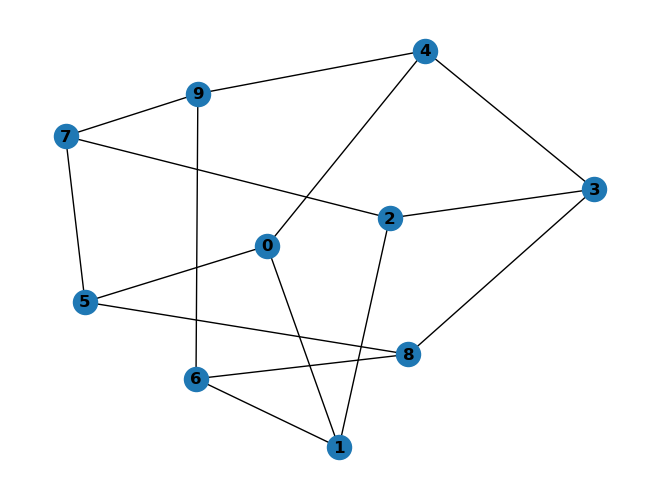

In [22]:
import matplotlib.pyplot as plt
import networkx as nx

G = nx.petersen_graph()
nx.draw(G, with_labels=True, font_weight='bold')

In [25]:
def degree_matrix_norm(a):
    return torch.diag(torch.pow(a.sum(dim=-1), -0.5))

def graph_laplacian_norm(a):
    size = a.shape[-1]
    D_norm = degree_matrix_norm(a)
    L_norm = torch.ones(size) - (D_norm @ a @ D_norm)
    return L_norm

# GNN이 할 수 있는 일

> ### Graph Classification : 각 그래프의 single label을 찾는 문제(지도학습)
> ### Node Classification : 보통 큰 그래프는 1000개 이상의 노드를 가지고 있는데 이때, 각 노드의 label를 찾음(반지도학습)

# GNN의 수식

# $ Y = (AX)W $ 
> ### W는 학습가능한 파라미터이고, Y는 출력값을 의미함
> ### A는 연결성에 대한 정보로 인접행렬이며 0또는 1의 값을 가짐
> ### 이번 실습에서는 A보다 더 표현력이 있는 연산자를 사용할것임. 
> ### 일반적으로, 그래프 시그널을 구함

In [49]:
import torch
import torch.nn as nn

def find_eigmax(L):
    with torch.no_grad():
        # 입력된 라플라시안 행렬의 고유값을 계산하여, 두개의 반환값중 첫번째 값을 e1에 저장
        e1, _ = torch.linalg.eig(L)
        # e1 행렬에서 고유값 중 가장 큰값을 반환
        return torch.max(e1.real).item()

def chebyshev_laplacian(X, laplacian, thetas, order):

    '''
    그래프에 Chebyshev 다항식 필터를 적용하기 위한 함수 

    thetas : Chebyshev 다항식의 계수
    order : Chebyshev 차수
    '''

    # Chebyshev 다항식 필터 적용한 결과 저장
    list_powers = []


    nodes = laplacian.shape[0]

    # Feature Matrix 
    T0 = X.float()
    eigmax = find_eigmax(laplacian)

    # L_rescaled : 입력하려는 라플라시안 행렬을 스케일링
    L_rescaled = (2 * laplacian / eigmax) - torch.eye(nodes)


    y = T0 * thetas[0]
    list_powers.append(y)

    # T1 : T0과 L_rescaled를 사용하여 계산한 다음 필터 적용 결과
    T1 = torch.matmul(L_rescaled, T0)

    list_powers.append(T1 * thetas[1])

    for k in range(2, order):
        T2 = 2 * torch.matmul(L_rescaled, T1) - T0
        list_powers.append((T2 * thetas[k]))
        T0, T1 = T1, T2
    
    # list_powers에 저장된 모든 필터 적용 결과 Stacking
    y_out = torch.stack(list_powers, dim=-1)
    # feature matrix 형태로 변환
    y_out = y_out.view(nodes, -1)

    return y_out


In [50]:
features = 3
out_features = 50
A = create_adj(10)
L = graph_laplacian_norm(A)
X = torch.rand(10, features)

power_order = 4 # p-hops
thetas = nn.Parameter(torch.rand(4))

out = chebyshev_laplacian(X, L, thetas, power_order)

print("ChebyShev approximation out powers concatenated: ", out.shape)

linear = nn.Linear(4 * 3, out_features)
layer_out = linear(out)

print("layer's output : ", layer_out.shape)

ChebyShev approximation out powers concatenated:  torch.Size([10, 12])
layer's output :  torch.Size([10, 50])


In [51]:
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F

def device_as(x, y):
    return x.to(y.device)

def calc_degree_matrix_norm(a):
    return torch.diag_embed(torch.pow(a.sum(dim=-1), -0.5))

def create_graph_laplacian_norm(a):
    size = a.shape[-1]
    a += device_as(torch.eye(size), a)
    D_norm = calc_degree_matrix_norm(a)
    L_norm = torch.bmm(torch.bmm(D_norm, a), D_norm)
    return L_norm

class GCN(nn.Module):
    '''
    Simple GCN Layer
    '''
    def __init__(self, in_features, out_features, bias=True):
        super().__init__()
        self.linear = nn.Linear(in_features, out_features, bias=bias)

    def forward(self, X, A):
        L = create_graph_laplacian_norm(A)
        x = self.linear(X)
        return torch.bmm(L, x)

In [62]:
import os
import torchnet as tnt

def indices_to_one_hot(number, nb_classes, label_dummy=-1):
    '''
    Convert an iterable of indices to one-hot encoded labels.
    '''
    if number == label_dummy:
        return np.zeros(nb_classes)
    else:
        return np.eye(nb_classes)[number]

def get_graph_signal(nx_graph):
    d = dict((k, v) for k, v in nx_graph.nodes.items())
    x = []
    invd = {}
    j = 0
    for k, v in d.items():
        x.append(v['attr_dict'])
        invd[k] = j
        j = j + 1
    return np.array(x)


def load_data(path, ds_name, use_node_labels=True, max_node_label=10):
    node2graph = {}
    Gs = []
    data = []
    dataset_graph_indicator = f"{ds_name}_graph_indicator.txt"
    dataset_adj = f"{ds_name}_A.txt"
    dataset_node_labels = f"{ds_name}_node_labels.txt"
    dataset_graph_labels = f"{ds_name}_graph_labels.txt"

    path_graph_indicator = os.path.join(path, dataset_graph_indicator)
    path_adj = os.path.join(path, dataset_adj)
    path_node_label = os.path.join(path, dataset_node_labels)
    path_labels = os.path.join(path, dataset_graph_labels)

    with open(path_graph_indicator, "r") as f:
        c = 1
        for line in f:
            node2graph[c] = int(line[:-1])
            if not node2graph[c] == len(Gs):
                Gs.append(nx.Graph())
            Gs[-1].add_node(c)
            c += 1
    
    with open(path_adj, "r") as f:
        for line in f:
            edge = line[:-1].split(",")
            edge[1] = edge[1].replace(" ", "")
            Gs[node2graph[int(edge[0])] - 1].add_edge(int(edge[0]), int(edge[1]))

    if use_node_labels:
        with open(path_node_label, "r") as f:
            c = 1
            for line in f:
                node_label = indices_to_one_hot(int(line[:-1]), max_node_label)
                Gs[node2graph[c] - 1].add_node(c, attr_dict=node_label)
                c += 1
    labels = []
    with open(path_labels, "r") as f:
        for line in f:
            labels.append(int(line[:-1]))

    return list(zip(Gs, labels)) 

def to_pytorch_dataset(dataset, label_offset=0, batch_size=1):
    list_set = []
    for graph, label in dataset:
        F, G = get_graph_signal(graph), nx.to_numpy_array(graph)
        numOfNodes = G.shape[0]
        F_tensor = torch.from_numpy(F).float()
        G_tensor = torch.from_numpy(G).float()

        if label == -1:
            label = 0
        
        label += label_offset

        list_set.append(tuple((F_tensor, G_tensor, label)))
    dataset_tnt = tnt.dataset.ListDataset(list_set)
    data_loader = torch.utils.data.DataLoader(dataset_tnt, shuffle=True, batch_size=batch_size)
    return data_loader
        


def create_loaders(dataset, batch_size, split_id, offset=-1):
    train_dataset = dataset[:split_id]
    val_dataset = dataset[split_id:]
    return to_pytorch_dataset(train_dataset, offset, batch_size), to_pytorch_dataset(val_dataset, offset, batch_size)

dataset = load_data(path='./MUTAG/', ds_name='MUTAG', use_node_labels=True, max_node_label=7)
train_dataset, val_dataset = create_loaders(dataset, batch_size=1, split_id=150, offset=0)


    

In [65]:
class GNN(nn.Module):
    def __init__(self, in_features=7, hidden_dim=64, classes=2, dropout=0.5):
        super(GNN, self).__init__()
    
        self.conv1 = GCN(in_features, hidden_dim)
        self.conv2 = GCN(hidden_dim, hidden_dim)
        self.conv3 = GCN(hidden_dim, hidden_dim)
        self.fc = nn.Linear(hidden_dim, classes)
        self.dropout = dropout
    
    def forward(self, x, A):
        x = self.conv1(x, A)
        x = F.relu(x)
        x = self.conv2(x, A)
        x = F.relu(x)
        x = self.conv3(x, A)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = x.mean(dim=1)

        return self.fc(x)

In [68]:
criterion = torch.nn.CrossEntropyLoss()
device = 'cuda' if torch.cuda.is_available() else 'cpu'

print(f'Training on {device}')

model = GNN(in_features=7, hidden_dim=128, classes=2).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

def train(train_loader):
    model.train() 

    for data in train_loader:
        optimizer.zero_grad()
        X, A, labels = data
        X, A, labels = X.to(device), A.to(device), labels.to(device) 
        out = model(X, A)
        loss = criterion(out, labels)
        loss.backward()
        optimizer.step()

def test(loader):
    model.eval()
    correct = 0
    for data in loader:
        X, A, labels = data
        X, A, labels = X.to(device), A.to(device), labels.to(device)
        out = model(X, A)
        pred = out.argmax(dim=1)
        correct += int((pred==labels).sum())
    return correct / len(loader.dataset)

Training on cpu


In [69]:
best_val = -1
for epoch in range(1, 241):
    train(train_dataset)
    train_acc = test(train_dataset)
    val_acc = test(val_dataset)
    if val_acc > best_val:
        best_val = val_acc
        epoch_best = epoch

    if epoch % 10 == 0:
        print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f} || Best Val Score: {best_val:.4f} (Epoch {epoch_best:03d}) ')

Epoch: 010, Train Acc: 0.6600, Val Acc: 0.6842 || Best Val Score: 0.6842 (Epoch 001) 
Epoch: 020, Train Acc: 0.6600, Val Acc: 0.6842 || Best Val Score: 0.6842 (Epoch 001) 
Epoch: 030, Train Acc: 0.7133, Val Acc: 0.6842 || Best Val Score: 0.7632 (Epoch 029) 
Epoch: 040, Train Acc: 0.7333, Val Acc: 0.6579 || Best Val Score: 0.7632 (Epoch 029) 
Epoch: 050, Train Acc: 0.7067, Val Acc: 0.6579 || Best Val Score: 0.7632 (Epoch 029) 
Epoch: 060, Train Acc: 0.7467, Val Acc: 0.6842 || Best Val Score: 0.7632 (Epoch 029) 
Epoch: 070, Train Acc: 0.7600, Val Acc: 0.6842 || Best Val Score: 0.7632 (Epoch 029) 
Epoch: 080, Train Acc: 0.7600, Val Acc: 0.7105 || Best Val Score: 0.7632 (Epoch 029) 
Epoch: 090, Train Acc: 0.7333, Val Acc: 0.6316 || Best Val Score: 0.7632 (Epoch 029) 
Epoch: 100, Train Acc: 0.7400, Val Acc: 0.6842 || Best Val Score: 0.7632 (Epoch 029) 
Epoch: 110, Train Acc: 0.7533, Val Acc: 0.7368 || Best Val Score: 0.7632 (Epoch 029) 
Epoch: 120, Train Acc: 0.7533, Val Acc: 0.6842 || Best